In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install scikit-image


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from skimage.feature import canny
from scipy.ndimage import sobel

In [3]:
# Constants for edge detection
MIN_CANNY_THRESHOLD = 1
MAX_CANNY_THRESHOLD = 400
threshold = 0.5  # Example threshold

In [4]:
def generate_shifts(max_shift):
    shifts = []
    for shift_y in range(-max_shift, max_shift + 1):
        for shift_x in range(-max_shift, max_shift + 1):
            shifts.append((shift_y, shift_x))
    return shifts

In [5]:
def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [6]:
def gradient_orientation(image):
    dx = sobel(image, axis=0, mode='constant')
    dy = sobel(image, axis=1, mode='constant')
    gradient = np.arctan2(dy, dx) * 180 / np.pi
    return gradient

In [7]:
def build_r_table(image, origin):
    edges = canny(image, low_threshold=MIN_CANNY_THRESHOLD,
                  high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)

    r_table = defaultdict(list)
    for (i, j), value in np.ndenumerate(edges):
        if value:
            r_table[gradient[i, j]].append((origin[0] - i, origin[1] - j))
    return r_table

In [8]:
def accumulate_gradients(r_table, grayImage):
    edges = canny(grayImage, low_threshold=MIN_CANNY_THRESHOLD,
                  high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)

    accumulator = np.zeros(grayImage.shape)
    for (i, j), value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i, j]]:
                accum_i, accum_j = i + r[0], j + r[1]
                if 0 <= accum_i < accumulator.shape[0] and 0 <= accum_j < accumulator.shape[1]:
                    accumulator[accum_i, accum_j] += 1
    return accumulator

In [9]:
def general_hough_closure(reference_image):
    referencePoint = (
        reference_image.shape[0] // 2, reference_image.shape[1] // 2)
    r_table = build_r_table(reference_image, referencePoint)

    def f(query_image):
        return accumulate_gradients(r_table, query_image)

    return f

In [10]:
def n_max(a, n):
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]

In [11]:
def overlay_reference_image(query_image, reference_image, position):
    '''
    Overlay the reference image on the query image at the specified position.
    '''
    ref_h, ref_w = reference_image.shape
    q_h, q_w = query_image.shape

    ref_h_half = ref_h // 2
    ref_w_half = ref_w // 2

    # Position where the top-left corner of the reference image should be placed
    pos_y, pos_x = position
    start_y = max(0, pos_y - ref_h_half)
    start_x = max(0, pos_x - ref_w_half)
    end_y = min(q_h, pos_y + ref_h_half)
    end_x = min(q_w, pos_x + ref_w_half)

    # Overlay reference image
    ref_start_y = ref_h_half - (pos_y - start_y)
    ref_start_x = ref_w_half - (pos_x - start_x)
    ref_end_y = ref_start_y + (end_y - start_y)
    ref_end_x = ref_start_x + (end_x - start_x)

    query_image[start_y:end_y, start_x:end_x] = np.maximum(
        query_image[start_y:end_y, start_x:end_x],
        reference_image[ref_start_y:ref_end_y, ref_start_x:ref_end_x]
    )

    return query_image

In [12]:
def multi_scale_and_shift_detection(reference_images, query_image, scales, shifts):
    best_accumulator = None
    best_position = None
    best_scale = 1
    best_shift = (0, 0)
    best_reference_image = None
    max_accumulator_value = 0

    for reference_image in reference_images:
        for scale in scales:
            # Resize the reference image
            scaled_reference_image = cv2.resize(
                reference_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

            # Apply Hough transform
            detect_s = general_hough_closure(scaled_reference_image)
            accumulator = detect_s(query_image)

            # Find the best shift for this scale
            for shift_y, shift_x in shifts:
                # Apply the shift
                shifted_accumulator = np.roll(accumulator, shift=(shift_y, shift_x), axis=(0, 1))
                max_value = shifted_accumulator.max()
                print(shift_x, shift_y, scale, max_value)
                
                if max_value >= max_accumulator_value:
                    max_accumulator_value = max_value
                    best_accumulator = shifted_accumulator
                    best_position = np.unravel_index(shifted_accumulator.argmax(), shifted_accumulator.shape)
                    best_scale = scale
                    best_shift = (shift_y, shift_x)
                    best_reference_image = scaled_reference_image

    return best_accumulator, best_position, best_scale, best_shift, best_reference_image


In [13]:
def test_general_hough(reference_images, query_image):
    scales = [0.5, 1.0, 1.5, 2.0, 1.25, 1.35, 1.65]  # Example scales
    shifts = [(10, 10), (0, 0), (-5, -5)]  # Example shifts
    
    best_accumulator, best_position, best_scale, best_shift, best_reference_image = multi_scale_and_shift_detection(
        reference_images, query_image, scales, shifts)

    plt.clf()
    plt.gray()

    fig = plt.figure()
    fig.add_subplot(2, 2, 1)
    plt.title('Best Reference Image')
    plt.imshow(best_reference_image, cmap='gray')

    fig.add_subplot(2, 2, 2)
    plt.title('Query Image with Red Points')

    # Convert query image to RGB
    query_image_colored = cv2.cvtColor(query_image, cv2.COLOR_GRAY2BGR)

    # Draw the detected position in red
    if best_position:
        i, j = best_position
        # Red circle with radius 5
        cv2.circle(query_image_colored, (j, i), 5, (0, 0, 255), -1)

    plt.imshow(query_image_colored)

    fig.add_subplot(2, 2, 3)
    plt.title('Accumulator')
    plt.imshow(best_accumulator, cmap='gray')

    fig.add_subplot(2, 2, 4)
    plt.title('Detection')

    # Overlay the reference image at the detected location
    scaled_reference_image = cv2.resize(
        best_reference_image, None, fx=best_scale, fy=best_scale, interpolation=cv2.INTER_LINEAR)
    
    # Adjust position for the best shift
    shifted_position = (best_position[0] + best_shift[0], best_position[1] + best_shift[1])
    
    overlayed_image = overlay_reference_image(
        query_image.copy(), scaled_reference_image, shifted_position)
    plt.imshow(overlayed_image, cmap='gray')

    plt.show()
    return

In [14]:
def rotate_image(image, angle):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]

    # Calculate the center of the image
    center = (w / 2, h / 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation
    rotated_image = cv2.warpAffine(image, M, (w, h))

    return rotated_image

In [15]:
def shapes_to_image(shapes, image_shape=(250, 250)):
    image = np.zeros(image_shape, dtype=np.uint8)
    for shape in shapes:
        for points in shape:
            for x, y in points:
                # Set pixel value to 255 (white) for shape points
                image[int(y), int(x)] = 255
    return image

In [16]:
def test1():
    reference_shapes_list = [
        read_csv_("utils/images/single_ellipse.csv"),
        read_csv_("utils/images/double_ellipse.csv")
    ]
    query_shapes = read_csv_("utils/tc/occlusion2.csv")

    # Convert shapes to images
    reference_images = [shapes_to_image(shapes) for shapes in reference_shapes_list]
    query_image = shapes_to_image(query_shapes)

    test_general_hough(reference_images, query_image)

In [17]:
def test2():
    reference_shapes_list = [
        read_csv_("utils/images/single_ellipse.csv"),
        read_csv_("utils/images/double_ellipse.csv")
    ]
    query_shapes = read_csv_("utils/images/occlusion1.csv")

    # Convert shapes to images
    reference_images = [shapes_to_image(shapes) for shapes in reference_shapes_list]
    query_image = shapes_to_image(query_shapes)

    test_general_hough(reference_images, query_image)

10 10 0.5 0.0
0 0 0.5 0.0
-5 -5 0.5 0.0
10 10 1.0 98.0
0 0 1.0 98.0
-5 -5 1.0 98.0
10 10 1.5 116.0
0 0 1.5 116.0
-5 -5 1.5 116.0
10 10 2.0 160.0
0 0 2.0 160.0
-5 -5 2.0 160.0
10 10 1.25 108.0
0 0 1.25 108.0
-5 -5 1.25 108.0
10 10 1.35 109.0
0 0 1.35 109.0
-5 -5 1.35 109.0
10 10 1.65 131.0
0 0 1.65 131.0
-5 -5 1.65 131.0
10 10 0.5 0.0
0 0 0.5 0.0
-5 -5 0.5 0.0
10 10 1.0 520.0
0 0 1.0 520.0
-5 -5 1.0 520.0
10 10 1.5 169.0
0 0 1.5 169.0
-5 -5 1.5 169.0
10 10 2.0 116.0
0 0 2.0 116.0
-5 -5 2.0 116.0
10 10 1.25 248.0
0 0 1.25 248.0
-5 -5 1.25 248.0
10 10 1.35 226.0
0 0 1.35 226.0
-5 -5 1.35 226.0
10 10 1.65 144.0
0 0 1.65 144.0
-5 -5 1.65 144.0


<Figure size 640x480 with 0 Axes>

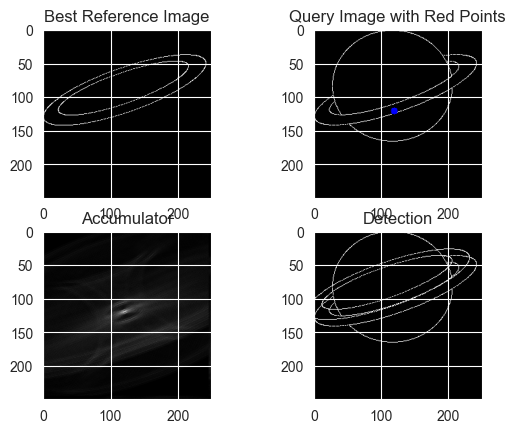

10 10 0.5 0.0
0 0 0.5 0.0
-5 -5 0.5 0.0
10 10 1.0 238.0
0 0 1.0 238.0
-5 -5 1.0 238.0
10 10 1.5 79.0
0 0 1.5 79.0
-5 -5 1.5 79.0
10 10 2.0 66.0
0 0 2.0 66.0
-5 -5 2.0 66.0
10 10 1.25 97.0
0 0 1.25 97.0
-5 -5 1.25 97.0
10 10 1.35 90.0
0 0 1.35 90.0
-5 -5 1.35 90.0
10 10 1.65 69.0
0 0 1.65 69.0
-5 -5 1.65 69.0
10 10 0.5 0.0
0 0 0.5 0.0
-5 -5 0.5 0.0
10 10 1.0 131.0
0 0 1.0 131.0
-5 -5 1.0 131.0
10 10 1.5 108.0
0 0 1.5 108.0
-5 -5 1.5 108.0
10 10 2.0 101.0
0 0 2.0 101.0
-5 -5 2.0 101.0
10 10 1.25 129.0
0 0 1.25 129.0
-5 -5 1.25 129.0
10 10 1.35 111.0
0 0 1.35 111.0
-5 -5 1.35 111.0
10 10 1.65 116.0
0 0 1.65 116.0
-5 -5 1.65 116.0


<Figure size 640x480 with 0 Axes>

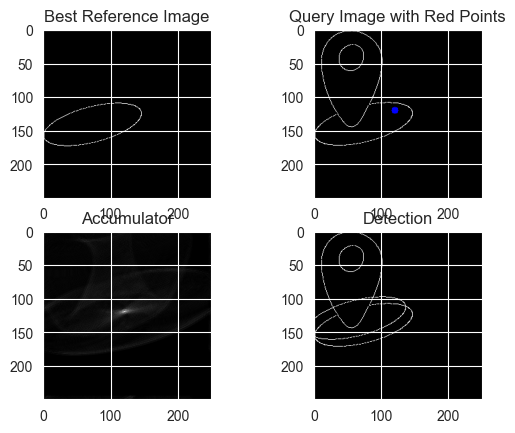

In [18]:
if __name__ == '__main__':
    test1()
    test2()